# [E-15] OCR Model Comparison
"Exploration Node 15. Character-readable Deep Learning" / 2022. 03. 03 (Thu) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Model Run & comparisons**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

## 1. Environment Setup

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import warnings 
warnings.filterwarnings(action='ignore')

## Source: https://textvqa.org/textocr/dataset/ 에서 랜덤으로 10개 추출

data_path = os.getenv('HOME')+ '/aiffel/ocr_python/Google/image'
file_list = os.listdir(data_path)
file_list

['4.jpg',
 '0.jpg',
 '1.jpg',
 '9.jpg',
 '3.jpg',
 '6.jpg',
 '2.jpg',
 '5.jpg',
 '8.jpg',
 '7.jpg']

## 2. Model Run & comparisons

In [2]:
## 1. Google OCR

def detect_text(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    #     for text in texts:
    print('\n"{}"'.format(texts[0].description))
    
    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in texts[0].bounding_poly.vertices])
    
    print('bounds: {}'.format(','.join(vertices)))
    
    if response.error.message:
        raise Exception(
        '{}\nFor more info on erroe messages, check:' 
        'https://cloud.google.com/apis/design/errors'.format(
        response.error.message))
    
    return texts[0].description

In [3]:
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.getenv('HOME') + '/aiffel/ocr_python/Google/json/google-api-hyeongju-key.json'

In [4]:
# Google OCR api 함수 호출
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(data_path, file))
    print()

[4.jpg]
Texts:

"C08
"
bounds: (248,499),(274,499),(274,527),(248,527)

[0.jpg]
Texts:

"London 2012
Fon 2012
BRA
GER
RECKERMA
London 2012
Lond
"
bounds: (121,288),(678,288),(678,652),(121,652)

[1.jpg]
Texts:

"-SINCE I1-
BYRNIE UTZ HATS
3ORSALH
STETSON
"
bounds: (80,157),(1011,157),(1011,332),(80,332)

[9.jpg]
Texts:

"..
HAM & CHEES
SDEAD
2450
MACHESE
MCONBORER
24.50
COLER
Saked
Fresh
PRANCE
12.
MONGOMAD
150
CHIN MONAY
ENSAYMADA
MONGO
12.50
BRE
"
bounds: (10,86),(1023,86),(1023,659),(10,659)

[3.jpg]
Texts:

"Parroquia
Cristo
Rey
SERVICIOS PARROQUIALES
NOTARIA
Lunes a Sabado 11:00 a.m, a 1:00 p.m. y 4:00 p.m. a 8:00p.m.
Martes y Domingos No hay servicio
Tel.
812 09 15
MISAS
7:00 a.m.
CEREMONIAS
Lunes a Sabado
8:00 a.m.
7:00 p.m.
Sabados
12:00 a.m. 6:00p.m. 7:00 p.m. 8:00 p.m.
7:00 8:00 9:00 12:00 a.m.
6:00 7:00 y 8:00 p.m.
A LA DIVINA PROVIDENCIA
Domingos
Dia 1 de cada mes
12:00 hrs.
PARA ENFERMOS
Viernes 1 de cada mes 12:00 hrs.
PLATICAS PARA MATRIMONIO
je Domingo de cada mes
de 8-

In [5]:
## 2. Keras-ocr
import matplotlib.pyplot as plt
import keras_ocr 
pipeline = keras_ocr.pipeline.Pipeline()
import warnings
warnings.filterwarnings(action='ignore') 

images = [keras_ocr.tools.read(os.path.join(data_path, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(data_path, file)]) for file in file_list]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


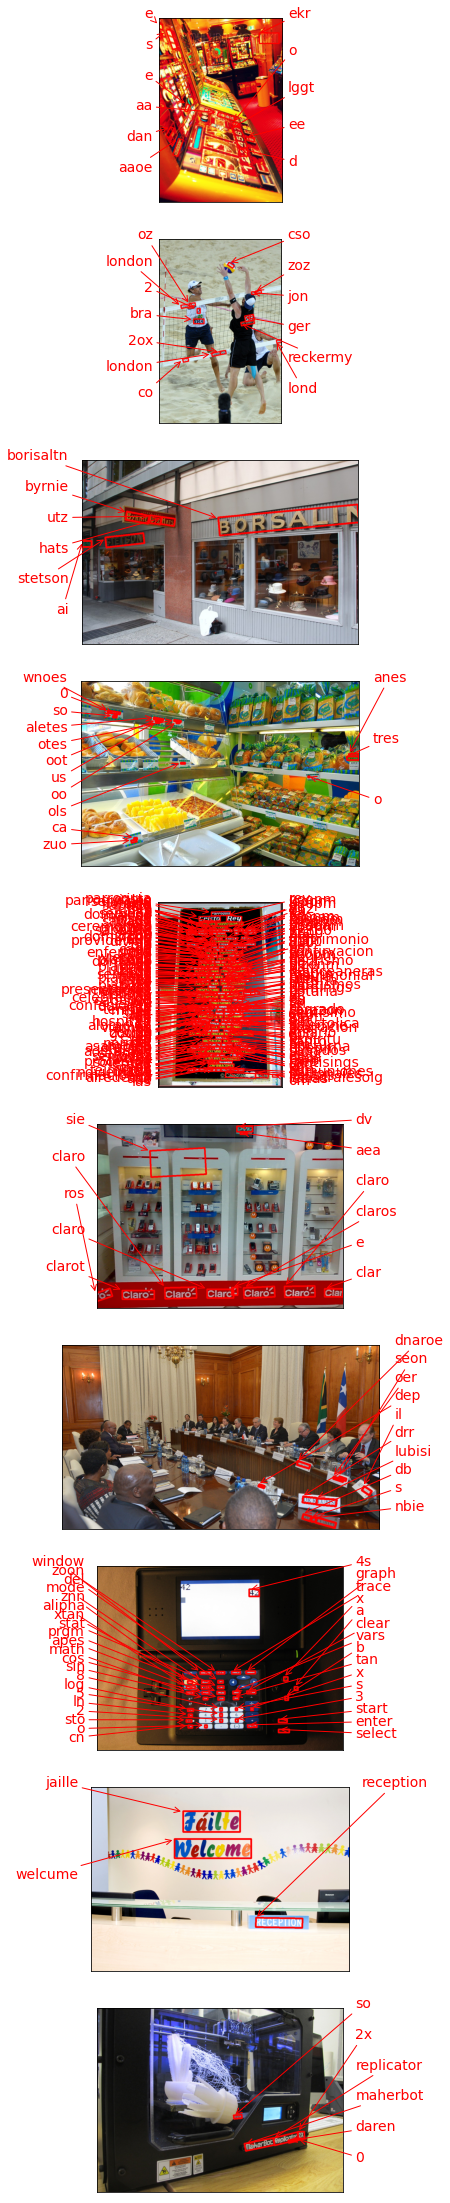

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [7]:
## 3. Pytesseract

import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped_images'

for file in file_list:
    print(f'[{file}]')
    try:
        crop_word_regions(os.path.join(data_path, file), save_dir)
    except:
        print(f'Characters Recognizing Failed from {file}')

[4.jpg]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
[0.jpg]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
[1.jpg]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
[9.jpg]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
[3.jpg]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0001.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0002.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0003.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0004.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0005.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0006.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0007.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0008.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0009.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0010.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0011.png


In [9]:
## Model Comparisons

def ocr_model_comparisons(file):
    
    print('\n[Google-OCR]')
    detect_text(os.path.join(data_path, file))
    print('\n[Keras-OCR]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Tesseract-OCR]')
    crop_word_regions(os.path.join(data_path, file), save_dir)


[Google-OCR]
Texts:

"London 2012
Fon 2012
BRA
GER
RECKERMA
London 2012
Lond
"
bounds: (121,288),(678,288),(678,652),(121,652)

[Keras-OCR]


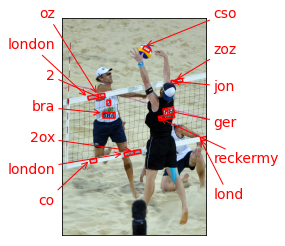


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png


In [10]:
ocr_model_comparisons('0.jpg')


[Google-OCR]
Texts:

"-SINCE I1-
BYRNIE UTZ HATS
3ORSALH
STETSON
"
bounds: (80,157),(1011,157),(1011,332),(80,332)

[Keras-OCR]


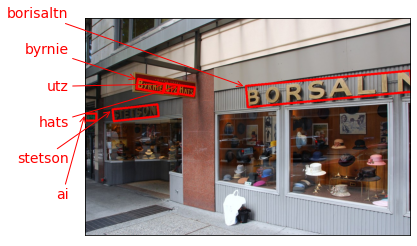


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png


In [11]:
ocr_model_comparisons('1.jpg')


[Google-OCR]
Texts:

"Parroquia
Cristo
Rey
SERVICIOS PARROQUIALES
NOTARIA
Lunes a Sabado 11:00 a.m, a 1:00 p.m. y 4:00 p.m. a 8:00p.m.
Martes y Domingos No hay servicio
Tel.
812 09 15
MISAS
7:00 a.m.
CEREMONIAS
Lunes a Sabado
8:00 a.m.
7:00 p.m.
Sabados
12:00 a.m. 6:00p.m. 7:00 p.m. 8:00 p.m.
7:00 8:00 9:00 12:00 a.m.
6:00 7:00 y 8:00 p.m.
A LA DIVINA PROVIDENCIA
Domingos
Dia 1 de cada mes
12:00 hrs.
PARA ENFERMOS
Viernes 1 de cada mes 12:00 hrs.
PLATICAS PARA MATRIMONIO
je Domingo de cada mes
de 8-00 am. a 3:00 p.m.
PLATICAS PARA CONFIRMACION
La última semana de cada mes
de 7:00 p.m. a 8:00p.m.
PLATICAS PARA BAUTIŠMO
Lunes y martes
de 7:00 p.m a 8:30n.m.
PLATICAS PARA QUINCEANERAS
Jáeves
7:00 p.m.
PRESENTACION MATRIMONIAL
Lunes, Miércoles y Viernes en horario de notaria (Previa cita
CELÉBRACION DE BAUTISMOS
Sábados 5:00 p.m. y Domingas 1:00 p.m.
CONFESIONÈS
Durante las misas en el templo o en la notaría
or las no. i. ia.ar:SAN tel. 825-12-48 La:1
617 25 24 Hospitar Sagrado Corazón
AL

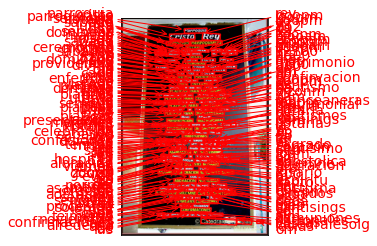


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0001.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0002.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0003.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0004.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0005.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0006.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0007.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0008.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0009.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0010.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0011.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0012.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0013.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0014.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0015.png
/aiffel/aiffel/ocr_pyth

In [12]:
ocr_model_comparisons('3.jpg')


[Google-OCR]
Texts:

"C08
"
bounds: (248,499),(274,499),(274,527),(248,527)

[Keras-OCR]


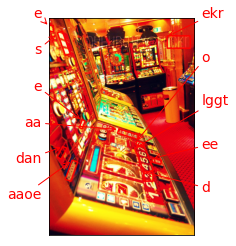


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png


In [13]:
ocr_model_comparisons('4.jpg')


[Google-OCR]
Texts:

"42
42
WINDOW
ZOOM
TRACE
GRAPH
MODE
DEL
ALPHA
X,T,8,0
STAT
MATH
APPS
PRGM
VARS
CLEAR
x-
SIN
Cos
TAN
B
LOG
7
9
X.
LN
6.
STO
3
START
CN
(-)
ENTER
SELECT
"
bounds: (340,76),(796,76),(796,692),(340,692)

[Keras-OCR]


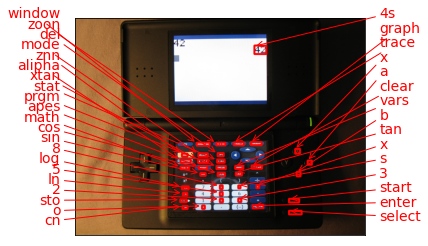


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png


In [14]:
ocr_model_comparisons('5.jpg')


[Google-OCR]
Texts:

"DVD
NOKIA
NOKA
ro Claro-
Claro- Claro- Claro- Claro- Clar
"
bounds: (1,13),(1023,13),(1023,733),(1,733)

[Keras-OCR]


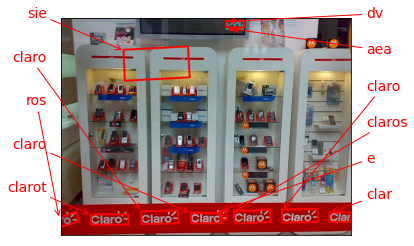


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0001.png


In [15]:
ocr_model_comparisons('6.jpg')


[Google-OCR]
Texts:

"Fáille
Welcome
大
lenovo
RECEPTION
"
bounds: (42,96),(963,96),(963,555),(42,555)

[Keras-OCR]


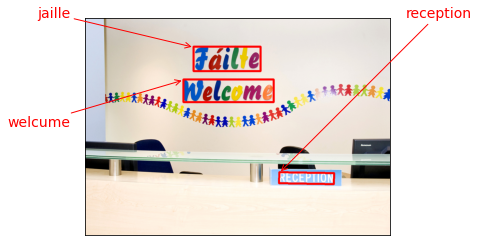


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0001.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0002.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0003.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0004.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0005.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0006.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0007.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0008.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0009.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0010.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0011.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0012.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0013.png
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0014.png


In [16]:
ocr_model_comparisons('8.jpg')


[Google-OCR]
Texts:

"..
HAM & CHEES
SDEAD
2450
MACHESE
MCONBORER
24.50
COLER
Saked
Fresh
PRANCE
12.
MONGOMAD
150
CHIN MONAY
ENSAYMADA
MONGO
12.50
BRE
"
bounds: (10,86),(1023,86),(1023,659),(10,659)

[Keras-OCR]


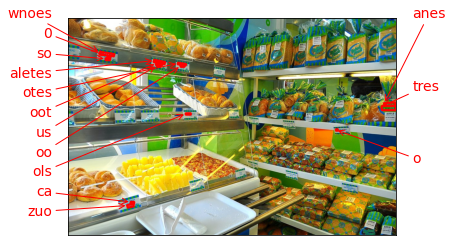


[Tesseract-OCR]
/aiffel/aiffel/ocr_python/tesseract_cropped_images/0000.png


In [17]:
ocr_model_comparisons('9.jpg')

## 3. Project Retrospective

+ Tesseract OCR이 구글의 후원 프로젝트임에도, 자체 개발한 Google OCR보다 크게 성능이 뒤지는 것은 아쉽게 느껴진다.
+ Tesseract으로 설치했는데, 라이브러리는 pytesseract으로 불러오다보니 초기 오타로 오류가 다수 발생했었다.
+ Google OCR -> Keras OCR -> Pytesseract 순으로 성능이 좋았다.
    - Keras OCR은 약간 기울어져 있는 그림은 정확도가 떨어지더라도 인식한 반면, Tesseract는 그렇지 못했다.
    - 7번 image의 경우는 3D 프린터 사진이었는데, 모델명이라도 인식을 할 수 있었을 것 같지만 Tesseract는 실패했다.
+ NLP로 대부분 구성되었던 Ex에서 이렇게 새로운 주제를 다룬 것 자체는 흥미로웠다.